# Stacked Autoencoder con PyTorch en MNIST

En este notebook, construiremos un stacked autoencoder sencillo utilizando PyTorch y el dataset MNIST.  
El flujo de trabajo será el siguiente:

1. Preparar el dataset (MNIST).
2. Crear el modelo de stacked autoencoder.
3. Entrenar el modelo.
4. Aplicar el modelo a algunas imágenes de prueba para ver sus reconstrucciones.
5. Aplicaciones sobre el espacio latente:

    a) Clustering: Realizar clustering en el espacio latente, comparar con las etiquetas, calcular porcentajes.  
    b) Reducción de dimensionalidad: Visualizar el espacio latente en 2D y colorear según la clase original.  
    c) Detección de anomalías: Comparar la distribución del error de reconstrucción entre las imágenes verdaderas y las imágenes generadas a partir de entradas aleatorias.

## 1) Preparando el Dataset MNIST

Descargaremos MNIST a través de `torchvision.datasets`, crearemos DataLoaders para entrenamiento y prueba.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Transformaciones para MNIST
transform = transforms.Compose([
    transforms.ToTensor(), # Convertir a tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalizar datos
])

# Descarga y carga del dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 64
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 2) Creación del Modelo: Stacked Autoencoder

Crearemos un autoencoder con varias capas en el encoder y decoder. Por ejemplo:

- Input: 28x28 = 784 features
- Encoder: 784 -> 256 -> 64
- Latent code: 64
- Decoder: 64 -> 256 -> 784

Luego daremos forma a las 784 salidas para que coincidan con la imagen original de 28x28.

In [4]:
class StackedAutoencoder(nn.Module):
    def __init__(self):
        super(StackedAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Tanh() # Usamos Tanh para mantener la salida entre -1 y 1, acorde a la normalización
        )
        
    def forward(self, x):
        # x: [batch, 1, 28, 28]
        x = x.view(x.size(0), -1) # Flatten
        z = self.encoder(x)
        out = self.decoder(z)
        out = out.view(x.size(0), 1, 28, 28)
        return out, z

## 3) Entrenamiento del Modelo

- Definimos el optimizador (Adam).
- Definimos la función de pérdida (MSE).
- Entrenamos durante varias épocas.

In [5]:
model = StackedAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        
        optimizer.zero_grad()
        outputs, _ = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/5, Loss: 0.0926
Epoch 2/5, Loss: 0.0439
Epoch 3/5, Loss: 0.0379
Epoch 4/5, Loss: 0.0349
Epoch 5/5, Loss: 0.0327


## 4) Reconstrucción de Imágenes de Prueba

Ahora veamos cómo el autoencoder reconstruye algunas imágenes del set de prueba.

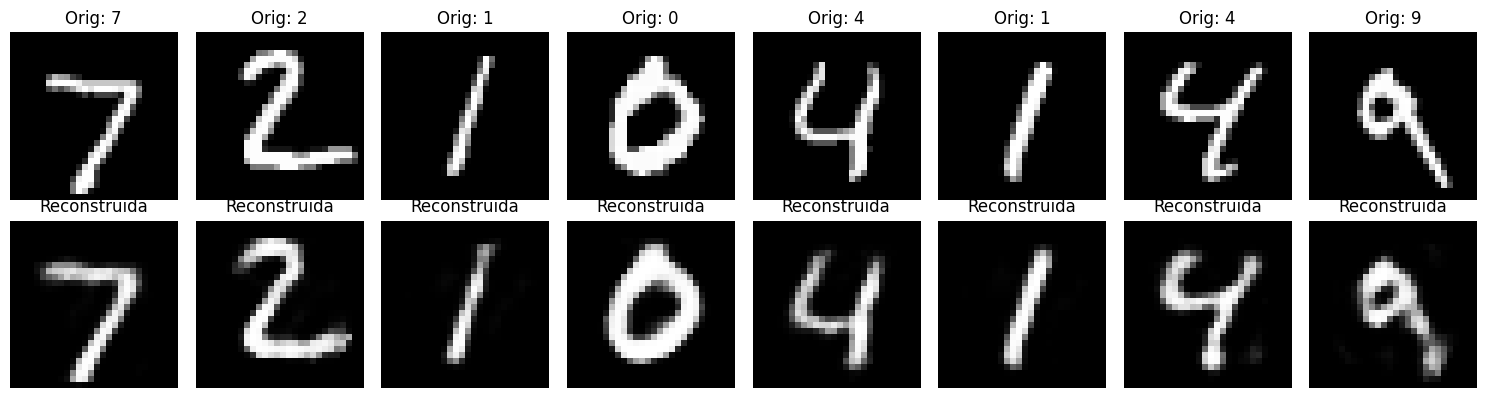

In [6]:
model.eval()
test_iter = iter(test_loader)
images, labels = next(test_iter)
images = images.to(device)
reconstructions, _ = model(images)
images = images.cpu().detach().numpy()
reconstructions = reconstructions.cpu().detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(15,4))
for i in range(8):
    axes[0][i].imshow(images[i].squeeze(), cmap='gray')
    axes[0][i].set_title(f"Orig: {labels[i].item()}")
    axes[0][i].axis('off')
    
    axes[1][i].imshow(reconstructions[i].squeeze(), cmap='gray')
    axes[1][i].set_title("Reconstruida")
    axes[1][i].axis('off')

plt.tight_layout()
plt.show()

## 5) Aplicaciones sobre el espacio latente

Ahora que el modelo está entrenado, podemos usar el encoder para obtener las representaciones latentes (64 dimensiones) de todo el set de prueba.

### a) Clustering en el espacio latente

1. Extraer las representaciones latentes del conjunto de prueba.
2. Aplicar un algoritmo de clustering (por ejemplo, K-Means) para dividir en 10 clusters.
3. Visualizar un histograma de la distribución de las clases por cluster.
4. Asignar la etiqueta mayoritaria a cada cluster y calcular el porcentaje de acierto.

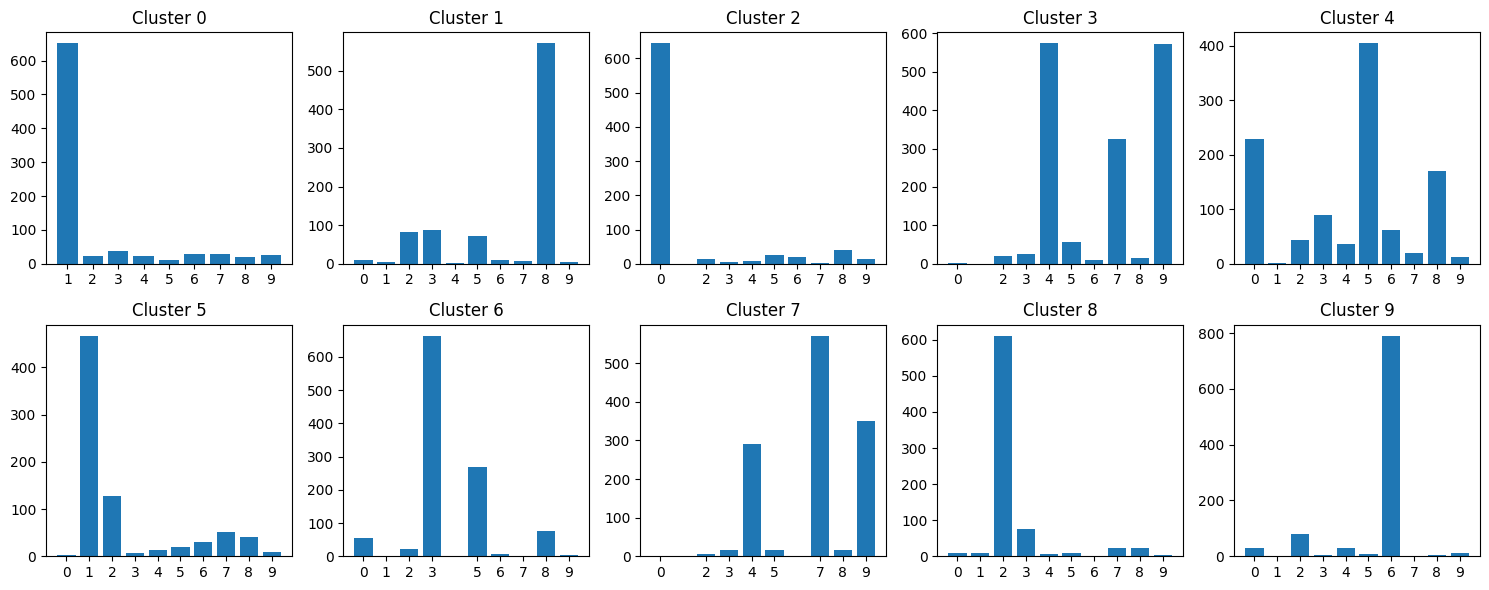

Aproximación de coincidencia de etiquetado basado en clusters: 59.46%


In [ ]:
from sklearn.cluster import KMeans
from collections import Counter

model.eval()
all_latents = []
all_labels = []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, z = model(imgs) # El modelo devuelve (reconstrucciones, latentes)
        all_latents.append(z.cpu().numpy())
        all_labels.append(lbls.cpu().numpy())

all_latents = np.concatenate(all_latents, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Clustering con KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(all_latents)

# Analicemos la composición de cada cluster
cluster_counts = [Counter(all_labels[clusters == i]) for i in range(10)]

# Histograma: conteo de clases por cluster
fig, axes = plt.subplots(2, 5, figsize=(15,6))
axes = axes.flatten()
for i in range(10):
    count_dict = cluster_counts[i]
    keys = list(count_dict.keys())
    vals = list(count_dict.values())
    axes[i].bar(keys, vals)
    axes[i].set_title(f"Cluster {i}")
    axes[i].set_xticks(keys)
plt.tight_layout()
plt.show()

# Asignar a cada cluster la clase mayoritaria
cluster_label_map = {}
for i in range(10):
    most_common_class, count = cluster_counts[i].most_common(1)[0]
    cluster_label_map[i] = most_common_class

# Calcular exactitud aproximada: cuántas etiquetas del test coinciden con el label asignado al cluster
correct = 0
for i in range(len(all_labels)):
    assigned_cluster = clusters[i]
    assigned_label = cluster_label_map[assigned_cluster]
    if assigned_label == all_labels[i]:
        correct += 1

accuracy = correct / len(all_labels)
print(f"Aproximación de coincidencia de etiquetado basado en clusters: {accuracy*100:.2f}%")

### b) Reducción de dimensionalidad

Para visualizar las representaciones latentes, usaremos alguna técnica de reducción a 2D (por ejemplo, t-SNE o PCA).

Luego coloreamos cada punto según su clase real, para observar si hay cierta separación natural.

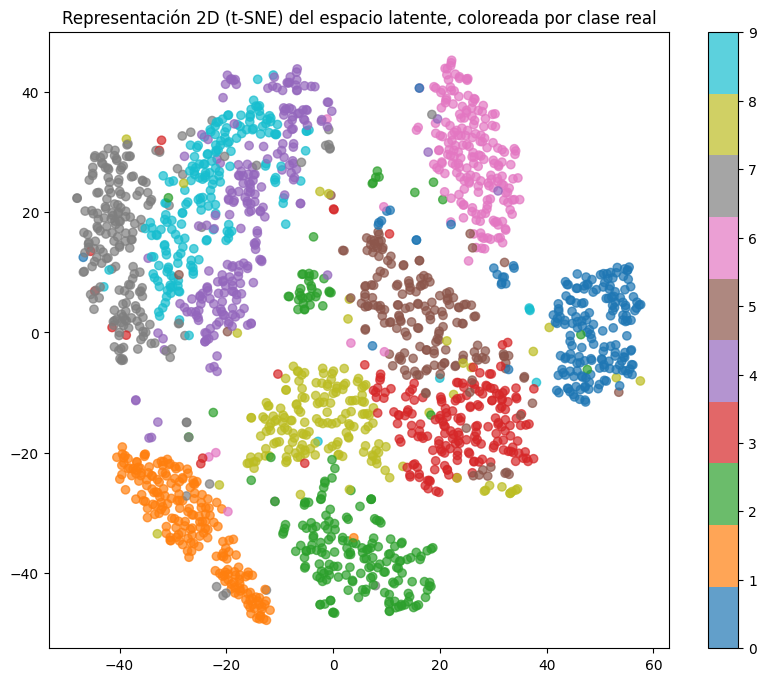

In [8]:
from sklearn.manifold import TSNE

# Reducimos el conjunto latente a 2000 muestras para acelerar t-SNE
sample_indices = np.random.choice(len(all_latents), 2000, replace=False)
sample_latents = all_latents[sample_indices]
sample_labels = all_labels[sample_indices]

tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(sample_latents)

plt.figure(figsize=(10,8))
scatter = plt.scatter(latents_2d[:,0], latents_2d[:,1], c=sample_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title("Representación 2D (t-SNE) del espacio latente, coloreada por clase real")
plt.show()

### c) Detección de anomalías

La idea es que el error de reconstrucción para datos "reales" sea generalmente menor que el de datos aleatorios (que no siguen la distribución de MNIST).

Pasos:
1. Calcular el error de reconstrucción para todas las imágenes del set de prueba.
2. Crear un histograma con la distribución del error.
3. Generar 100 entradas aleatorias (por ejemplo, ruido normal), pasarlas por el AE y calcular el error.
4. Comparar el histograma de errores de los datos reales con el de los datos "aleatorios".

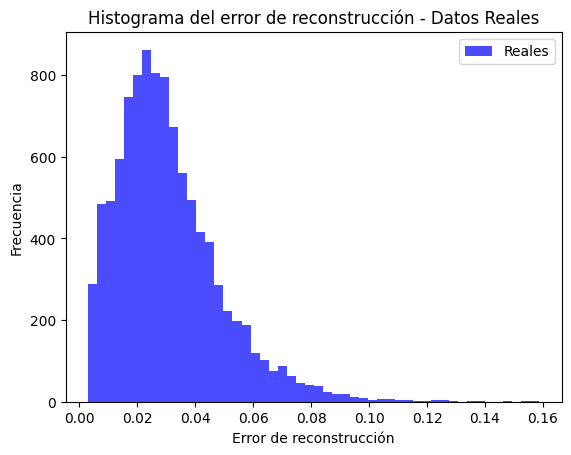

In [9]:
# Error de reconstrucción en el set de prueba
model.eval()
reconstruction_errors = []
with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        recons, _ = model(imgs)
        loss = torch.mean((recons - imgs)**2, dim=[1,2,3])
        reconstruction_errors.append(loss.cpu().numpy())
reconstruction_errors = np.concatenate(reconstruction_errors)

plt.hist(reconstruction_errors, bins=50, alpha=0.7, color='blue', label='Reales')
plt.title("Histograma del error de reconstrucción - Datos Reales")
plt.xlabel("Error de reconstrucción")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

Ahora generamos 100 imágenes aleatorias. Una forma simple es generar tensores con ruido gaussiano y normalizarlos similarmente.  
Luego aplicamos el AE y medimos el error de reconstrucción.

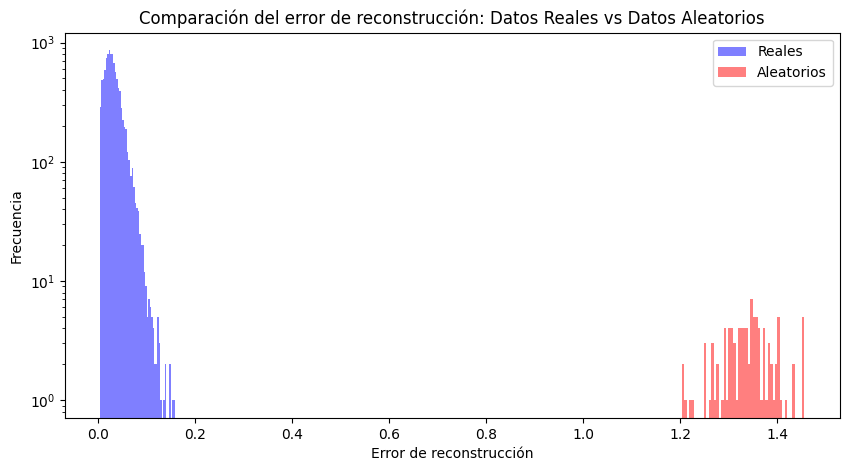

In [11]:
# Generar 100 imágenes aleatorias con dimensiones [100, 1, 28, 28]
random_images = torch.randn(100, 1, 28, 28) * 0.5 + 0.5  # Con medias y varianzas similares a MNIST normalizado
random_images = random_images.to(device)

model.eval()
with torch.no_grad():
    recons_random, _ = model(random_images)
    random_errors = torch.mean((recons_random - random_images)**2, dim=[1,2,3]).cpu().numpy()

plt.figure(figsize=(10,5))

# Graficar ambos histogramas en la misma figura, uno al lado del otro
plt.hist(reconstruction_errors, bins=50, alpha=0.5, color='blue', label='Reales')
plt.hist(random_errors, bins=50, alpha=0.5, color='red', label='Aleatorios')
plt.title("Comparación del error de reconstrucción: Datos Reales vs Datos Aleatorios")
plt.xlabel("Error de reconstrucción")
plt.ylabel("Frecuencia")
# Escala logarítmica en el eje y para visualizar mejor
plt.yscale('log')
plt.legend()
plt.show()

# Conclusiones

- Hemos entrenado un stacked autoencoder en MNIST.
- Observamos las reconstrucciones de las imágenes de prueba.
- Aplicamos clustering en el espacio latente y logramos asignar etiquetas a los clusters con un cierto nivel de precisión.
- Visualizamos la representación 2D del espacio latente mostrando que la estructura se correlaciona con las clases.
- Para la detección de anomalías, vimos cómo el error de reconstrucción es diferente para datos reales vs datos aleatorios, lo que sugiere que el AE captura la distribución de las cifras y produce mayor error en entradas fuera de la distribución.